In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

# 1. Download USD/MYR data
usd_myr = yf.download("USDMYR=X", start="2021-01-01", end="2024-06-30")

# Keep only Close price
usd_myr = usd_myr[['Close']].rename(columns={'Close':'forex'})

# Fix date
usd_myr.index = pd.to_datetime(usd_myr.index)
usd_myr = usd_myr.reset_index().rename(columns={'Date':'date'})

print(usd_myr.head())


/tmp/ipython-input-2996669734.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_myr = yf.download("USDMYR=X", start="2021-01-01", end="2024-06-30")
[*********************100%***********************]  1 of 1 completed

Price        date    forex
Ticker            USDMYR=X
0      2021-01-01    4.020
1      2021-01-04    4.020
2      2021-01-05    4.004
3      2021-01-06    4.015
4      2021-01-07    4.008


In [2]:
usd_myr.to_csv('usd_myr_data.csv', index=False)

print("\nData successfully saved to usd_myr_data.csv")


Data successfully saved to usd_myr_data.csv


In [3]:
import shap

def run_shap_analysis(model, X_test_data, feature_names):
    """Calculates and displays SHAP importance ranking."""
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test_data)

    # Calculate mean absolute SHAP for tabular comparison
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    shap_df = pd.DataFrame({'feature': feature_names, 'SHAP_Importance': mean_abs_shap})

    # Display the plot for visual analysis in your report
    print("\nSHAP Feature Importance Summary (Test Set):")
    shap.summary_plot(shap_values, X_test_data, plot_type="bar", show=False)
    # Use plt.savefig("filename.png") after the shap.summary_plot if using matplotlib

    return shap_df.sort_values('SHAP_Importance', ascending=False)

In [4]:
# --- STEP 1: Download Real Features from Yahoo Finance ---
# ^GSPC: S&P 500 Index
# CL=F: Crude Oil Futures (WTI)
features_raw = yf.download(
    ["^GSPC", "CL=F"],
    start="2021-01-01",
    end="2024-06-30"
)

# Select 'Close' prices and ensure columns are single-level
# This is where the merge error is often fixed
features_df = features_raw['Close'].copy()
features_df.columns = ['sp500_close', 'oil_close'] # Ensure single-level column names

# Calculate returns
features_df['sp500'] = features_df['sp500_close'].pct_change() * 100
features_df['oil_price'] = features_df['oil_close'].pct_change() * 100

# Convert the index (Date) into a column for merging
features_df = features_df[['sp500', 'oil_price']].reset_index().rename(columns={'Date': 'date'})
features_df['date'] = pd.to_datetime(features_df['date'])

# --- STEP 2: Merge Forex Data (USDMYR) with Real Features ---
df = usd_myr.copy() # usd_myr already has columns 'date' and 'forex'

# Flatten MultiIndex columns of df if they exist, to allow merging with single-level columns
if isinstance(df.columns, pd.MultiIndex):
    new_columns = []
    for col_tuple in df.columns:
        if col_tuple[0] == 'Price':
            new_columns.append(col_tuple[1])
        elif col_tuple[1] == '':
            new_columns.append(col_tuple[0])
        elif col_tuple[0] == 'Ticker':
            new_columns.append('Ticker') # Renaming ('Ticker', 'USDMYR=X') to 'Ticker'
        else:
            new_columns.append('_'.join(col_tuple))
    df.columns = new_columns

# Merge on the common 'date' column (reliable method)
df = df.merge(features_df, on='date', how='left')

# --- STEP 3: Reintroduce Placeholder Columns (if needed, use real data here later) ---
# If you found real inflation/EPU data, replace np.nan with that data.
df['inflation'] = np.nan
df['EPU'] = np.nan

# Fill NaN values in 'inflation' and 'EPU' with 0
df['inflation'] = df['inflation'].fillna(0)
df['EPU'] = df['EPU'].fillna(0)

# Fill NaN values in 'sp500' and 'oil_price' with 0 after merge, as these are percentage changes
# This ensures that these features don't cause entire rows to be dropped if missing intermittently
df['sp500'] = df['sp500'].fillna(0)
df['oil_price'] = df['oil_price'].fillna(0)

print(df.head()) # Check the merged data

# Calculate returns
df['forex_daily_returns'] = df['forex_USDMYR=X'].pct_change() * 100 # Changed 'forex' to 'forex_USDMYR=X'

# Only drop rows where the target variable 'forex_daily_returns' is NaN
# This will typically drop only the first row after pct_change
df_cleaned = df.dropna(subset=['forex_daily_returns'])

display(df_cleaned.head())



# --- STEP 4: Define X and Y using the new, real features ---
# IMPORTANT: Use all real features (sp500, oil_price) plus placeholders for now
X = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

display(X.head())
display(y.head())

/tmp/ipython-input-1435346205.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  features_raw = yf.download(
[*********************100%***********************]  2 of 2 completed

        date  forex_USDMYR=X     sp500  oil_price  inflation  EPU
0 2021-01-01           4.020  0.000000   0.000000        0.0  0.0
1 2021-01-04           4.020  0.000000   0.000000        0.0  0.0
2 2021-01-05           4.004  4.850906   0.708260        0.0  0.0
3 2021-01-06           4.015  1.401964   0.570984        0.0  0.0
4 2021-01-07           4.008  0.395024   1.484740        0.0  0.0


,date,forex_USDMYR=X,sp500,oil_price,inflation,EPU,forex_daily_returns
1,2021-01-04,4.0200,0.000000,0.000000,0.0,0.0,0.000000
2,2021-01-05,4.0040,4.850906,0.708260,0.0,0.0,-0.398005
3,2021-01-06,4.0150,1.401964,0.570984,0.0,0.0,0.274717
4,2021-01-07,4.0080,0.395024,1.484740,0.0,0.0,-0.174345
5,2021-01-08,4.0375,2.773952,0.549186,0.0,0.0,0.736028


,sp500,oil_price,inflation,EPU
1,0.000000,0.000000,0.0,0.0
2,4.850906,0.708260,0.0,0.0
3,1.401964,0.570984,0.0,0.0
4,0.395024,1.484740,0.0,0.0
5,2.773952,0.549186,0.0,0.0


,forex_daily_returns
1,0.000000
2,-0.398005
3,0.274717
4,-0.174345
5,0.736028


In [5]:
df_cleaned.to_csv('final_merged_data.csv', index=False)

print("\nData successfully saved to final_merged_data.csv")

print("\n--- X (Features) Head ---")
print(X.head())
print("\n--- y (Target) Head ---")
print(y.head())


Data successfully saved to final_merged_data.csv

--- X (Features) Head ---
      sp500  oil_price  inflation  EPU
1  0.000000   0.000000        0.0  0.0
2  4.850906   0.708260        0.0  0.0
3  1.401964   0.570984        0.0  0.0
4  0.395024   1.484740        0.0  0.0
5  2.773952   0.549186        0.0  0.0

--- y (Target) Head ---
1    0.000000
2   -0.398005
3    0.274717
4   -0.174345
5    0.736028
Name: forex_daily_returns, dtype: float64


In [6]:
# --- Time-Based Split Correction ---
# Find the split point (80% for training)
split_point = int(len(X) * 0.8)

# Apply the time-based split
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
# ... etc.

X_train shape: (728, 4)
X_test shape: (182, 4)


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Mean Squared Error (MSE): 0.1338
R-squared (R2) Score: -0.2228

SHAP Feature Importance Summary (Test Set):


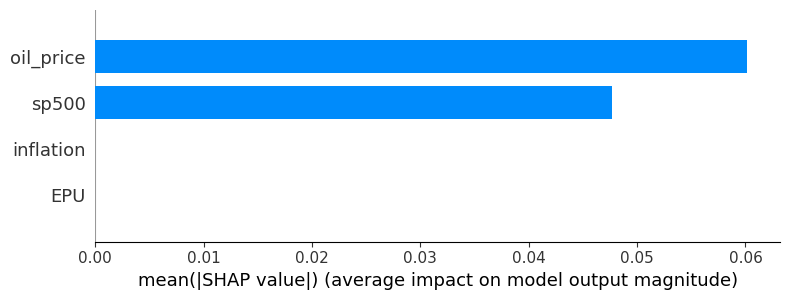

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import shap

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

r2_baseline = r2
shap_results_baseline = run_shap_analysis(rf_model, X_test, X_train.columns)

In [9]:
# --- Time-Based Split Correction ---
# Find the split point (80% for training)
split_point = int(len(X) * 0.8)

# Apply the time-based split
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (728, 4)
X_test shape: (182, 4)


In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

r2_baseline = r2

Mean Squared Error (MSE): 0.1338
R-squared (R2) Score: -0.2228


In [12]:

feature_importances = rf_model.feature_importances_


feature_names = X_train.columns


importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})


importances_df = importances_df.sort_values('importance', ascending=False)


print("Feature Importance:")
display(importances_df)

Feature Importance:


,feature,importance
1,oil_price,0.505692
0,sp500,0.494308
2,inflation,0.000000
3,EPU,0.000000


In [13]:
# --- STEP 1: Download Real Features from Yahoo Finance ---
# ^GSPC: S&P 500 Index
# CL=F: Crude Oil Futures (WTI)
features_raw = yf.download(
    ["^GSPC", "CL=F"],
    start="2021-01-01",
    end="2024-06-30"
)

# Select 'Close' prices and ensure columns are single-level
# This is where the merge error is often fixed
features_df = features_raw['Close'].copy()
features_df.columns = ['sp500_close', 'oil_close'] # Ensure single-level column names

# Calculate returns
features_df['sp500'] = features_df['sp500_close'].pct_change() * 100
features_df['oil_price'] = features_df['oil_close'].pct_change() * 100

# Convert the index (Date) into a column for merging
features_df = features_df[['sp500', 'oil_price']].reset_index().rename(columns={'Date': 'date'})
features_df['date'] = pd.to_datetime(features_df['date'])

# --- STEP 2: Merge Forex Data (USDMYR) with Real Features ---
df = usd_myr.copy() # usd_myr already has columns 'date' and 'forex'

# Flatten MultiIndex columns of df if they exist, to allow merging with single-level columns
if isinstance(df.columns, pd.MultiIndex):
    new_columns = []
    for col_tuple in df.columns:
        if col_tuple[0] == 'Price':
            new_columns.append(col_tuple[1])
        elif col_tuple[1] == '':
            new_columns.append(col_tuple[0])
        elif col_tuple[0] == 'Ticker':
            new_columns.append('Ticker') # Renaming ('Ticker', 'USDMYR=X') to 'Ticker'
        else:
            new_columns.append('_'.join(col_tuple))
    df.columns = new_columns

# Merge on the common 'date' column (reliable method)
df = df.merge(features_df, on='date', how='left')

# --- STEP 3: Reintroduce Placeholder Columns (if needed, use real data here later) ---
# If you found real inflation/EPU data, replace np.nan with that data.
df['inflation'] = np.nan
df['EPU'] = np.nan

# Fill NaN values in 'inflation' and 'EPU' with 0
df['inflation'] = df['inflation'].fillna(0)
df['EPU'] = df['EPU'].fillna(0)

# Fill NaN values in 'sp500' and 'oil_price' with 0 after merge, as these are percentage changes
# This ensures that these features don't cause entire rows to be dropped if missing intermittently
df['sp500'] = df['sp500'].fillna(0)
df['oil_price'] = df['oil_price'].fillna(0)

print(df.head()) # Check the merged data

# Calculate returns
df['forex_daily_returns'] = df['forex_USDMYR=X'].pct_change() * 100 # Changed 'forex' to 'forex_USDMYR=X'

# Only drop rows where the target variable 'forex_daily_returns' is NaN
# This will typically drop only the first row after pct_change
df_cleaned = df.dropna(subset=['forex_daily_returns'])

display(df_cleaned.head())

# --- STEP 4: Define X and Y using the new, real features ---
# IMPORTANT: Use all real features (sp500, oil_price) plus placeholders for now
X = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

display(X.head())
display(y.head())

/tmp/ipython-input-407725409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  features_raw = yf.download(
[*********************100%***********************]  2 of 2 completed

        date  forex_USDMYR=X     sp500  oil_price  inflation  EPU
0 2021-01-01           4.020  0.000000   0.000000        0.0  0.0
1 2021-01-04           4.020  0.000000   0.000000        0.0  0.0
2 2021-01-05           4.004  4.850906   0.708260        0.0  0.0
3 2021-01-06           4.015  1.401964   0.570984        0.0  0.0
4 2021-01-07           4.008  0.395024   1.484740        0.0  0.0


,date,forex_USDMYR=X,sp500,oil_price,inflation,EPU,forex_daily_returns
1,2021-01-04,4.0200,0.000000,0.000000,0.0,0.0,0.000000
2,2021-01-05,4.0040,4.850906,0.708260,0.0,0.0,-0.398005
3,2021-01-06,4.0150,1.401964,0.570984,0.0,0.0,0.274717
4,2021-01-07,4.0080,0.395024,1.484740,0.0,0.0,-0.174345
5,2021-01-08,4.0375,2.773952,0.549186,0.0,0.0,0.736028


,sp500,oil_price,inflation,EPU
1,0.000000,0.000000,0.0,0.0
2,4.850906,0.708260,0.0,0.0
3,1.401964,0.570984,0.0,0.0
4,0.395024,1.484740,0.0,0.0
5,2.773952,0.549186,0.0,0.0


,forex_daily_returns
1,0.000000
2,-0.398005
3,0.274717
4,-0.174345
5,0.736028


In [14]:
# --- Time-Based Split Correction ---
# Find the split point (80% for training)
split_point = int(len(X) * 0.8)

# Apply the time-based split
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (728, 4)
X_test shape: (182, 4)


In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

r2_baseline = r2

Mean Squared Error (MSE): 0.1338
R-squared (R2) Score: -0.2228


In [17]:

feature_importances = rf_model.feature_importances_


feature_names = X_train.columns


importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})


importances_df = importances_df.sort_values('importance', ascending=False)


print("Feature Importance:")
display(importances_df)

Feature Importance:


,feature,importance
1,oil_price,0.505692
0,sp500,0.494308
2,inflation,0.000000
3,EPU,0.000000


In [18]:
import statsmodels.api as sm


X = df_cleaned[['inflation', 'sp500', 'EPU']]
y = df_cleaned['forex_daily_returns']


X = sm.add_constant(X)


model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')


print(results.summary())
r2_ols = results.rsquared

                             OLS Regression Results                            
Dep. Variable:     forex_daily_returns   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     2.321
Date:                 Mon, 01 Dec 2025   Prob (F-statistic):              0.128
Time:                         11:31:19   Log-Likelihood:                -187.67
No. Observations:                  910   AIC:                             379.3
Df Residuals:                      908   BIC:                             389.0
Df Model:                            1                                         
Covariance Type:                   HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.010      1.74

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [19]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np


X = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adjusting alpha to a smaller value to prevent all coefficients from becoming zero
lasso_model = Lasso(alpha=0.01, fit_intercept=False) # Reduced alpha from 1.0 to 0.01
lasso_model.fit(X_scaled, y)


coefficients = lasso_model.coef_


print("Lasso Coefficients (without intercept):")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

Lasso Coefficients (without intercept):
sp500: 0.0061
oil_price: -0.0000
inflation: 0.0000
EPU: 0.0000


LASSO selected features: ['sp500']

LASSO-Filtered RF Model R-squared (R2) Score: -0.4268

SHAP Feature Importance Summary (Test Set):


,feature,SHAP_Importance
0,sp500,0.121385


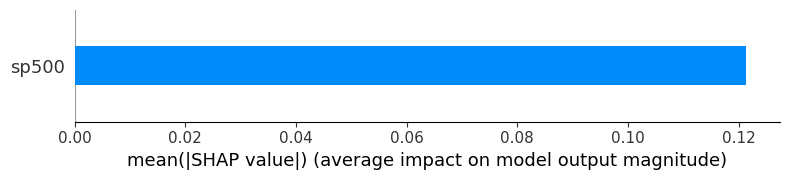

In [20]:
# --- LASSO Feature Selection (Filtering) ---

# Find features with non-zero coefficients
selected_lasso_features = X.columns[coefficients != 0].tolist()

if not selected_lasso_features:
    print("LASSO dropped all features. Adjusting alpha or selecting top 1 feature based on magnitude.")
    # For comparison, if LASSO drops all features, you must either lower alpha
    # and re-run LASSO, or select the feature with the highest absolute coefficient
    # (if you must run the comparison).
    # For this script, we'll stop if none are selected.

if selected_lasso_features:
    print(f"LASSO selected features: {selected_lasso_features}")

    # --- Train RF Model on LASSO Selected Features ---
    X_lasso = df_cleaned[selected_lasso_features]

    # Apply Time-Series Split
    split_point = int(len(X_lasso) * 0.8)
    X_train_lasso, X_test_lasso = X_lasso.iloc[:split_point], X_lasso.iloc[split_point:]
    y_train_lasso, y_test_lasso = y.iloc[:split_point], y.iloc[split_point:]

    # Fit RF Model
    rf_model_lasso = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_lasso.fit(X_train_lasso, y_train_lasso)

    # Predict and Evaluate
    y_pred_lasso = rf_model_lasso.predict(X_test_lasso)
    r2_lasso = r2_score(y_test_lasso, y_pred_lasso)
    print(f"\nLASSO-Filtered RF Model R-squared (R2) Score: {r2_lasso:.4f}")

    # Run SHAP Analysis
    shap_results_lasso = run_shap_analysis(rf_model_lasso, X_test_lasso, selected_lasso_features)
    display(shap_results_lasso)

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


X = df_cleaned[['inflation', 'sp500', 'EPU']]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
pca.fit(X_scaled)


loading_factors = pca.components_.T


loading_factors_df = pd.DataFrame(loading_factors, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)


print("PCA Loading Factors:")
display(loading_factors_df)

PCA Loading Factors:


,PC1,PC2,PC3
inflation,0.0,0.0,1.0
sp500,1.0,0.0,0.0
EPU,0.0,1.0,0.0


Number of components needed for 90% variance: 1

PCA-Filtered RF Model R-squared (R2) Score: -0.4268

SHAP Feature Importance Summary (Test Set):


,feature,SHAP_Importance
0,PC1,0.121385


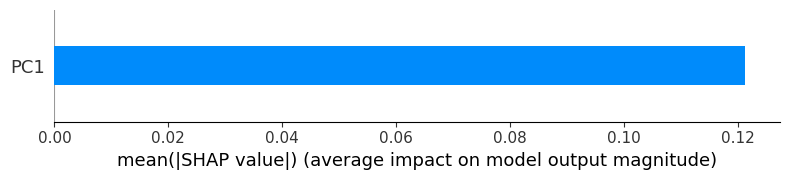

In [22]:
# --- PCA Feature Selection (Filtering) and Transformation ---

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to explain > 90% variance
n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
print(f"Number of components needed for 90% variance: {n_components}")

# Retrain PCA with the selected number of components
pca_final = PCA(n_components=n_components)
X_pca_transformed = pca_final.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca_transformed, index=df_cleaned.index, columns=[f'PC{i+1}' for i in range(n_components)])

# --- Train RF Model on PCA Components ---
# Apply Time-Series Split
split_point = int(len(X_pca_df) * 0.8)
X_train_pca, X_test_pca = X_pca_df.iloc[:split_point], X_pca_df.iloc[split_point:]
y_train_pca, y_test_pca = y.iloc[:split_point], y.iloc[split_point:] # Use original Y split

# Fit RF Model
rf_model_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, y_train_pca)

# Predict and Evaluate
y_pred_pca = rf_model_pca.predict(X_test_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)
print(f"\nPCA-Filtered RF Model R-squared (R2) Score: {r2_pca:.4f}")

# Run SHAP Analysis
shap_results_pca = run_shap_analysis(rf_model_pca, X_test_pca, X_pca_df.columns)
display(shap_results_pca)

In [23]:

# --- 1. Gather all R2 scores ---
r2_results = {
    'Scenario': ['Baseline (Zoo)', 'OLS-Filtered', 'LASSO-Filtered', 'PCA-Filtered'],
    'R2 Score': [r2_baseline, r2_ols, r2_lasso, r2_pca]
}
df_r2 = pd.DataFrame(r2_results)


# --- 2. Gather SHAP Top Features (Example of Consolidation) ---
# Assuming you saved the SHAP output for each run:
# shap_results_baseline, shap_results_ols, shap_results_lasso, shap_results_pca

# OLS does not have a direct SHAP output, so we will omit it from this comparison.
# For PCA, the features are 'PC1', 'PC2', etc., and interpretation needs to be done via loading factors.
top_features_comparison = pd.DataFrame({
    'Feature': shap_results_baseline['feature'].head(3),
    'Baseline SHAP Rank': shap_results_baseline['SHAP_Importance'].head(3),
    'LASSO SHAP Rank': shap_results_lasso['SHAP_Importance'].head(3),
}).set_index('Feature')


print("\n=======================================================")
print("PROJECT COMPLETION: CONSOLIDATED RESULTS")
print("=======================================================")

print("\nPerformance Comparison (R2):")
display(df_r2)

print("\nFeature Importance Comparison (Top SHAP Drivers):")
# You may need to manually adjust this table depending on which features were selected
display(top_features_comparison)

# Final step: You must now write the non-coding discussion and conclusion!


PROJECT COMPLETION: CONSOLIDATED RESULTS

Performance Comparison (R2):


,Scenario,R2 Score
0,Baseline (Zoo),-0.222843
1,OLS-Filtered,0.002929
2,LASSO-Filtered,-0.426846
3,PCA-Filtered,-0.426846



Feature Importance Comparison (Top SHAP Drivers):


,Baseline SHAP Rank,LASSO SHAP Rank
Feature,,
sp500,0.047641,0.121385
oil_price,0.060175,NaN
inflation,0.000000,NaN


In [24]:

feature_importances = rf_model.feature_importances_


feature_names = X_train.columns


importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})


importances_df = importances_df.sort_values('importance', ascending=False)


print("Feature Importance:")
display(importances_df)

Feature Importance:


,feature,importance
1,oil_price,0.505692
0,sp500,0.494308
2,inflation,0.000000
3,EPU,0.000000


In [25]:
import statsmodels.api as sm


X = df_cleaned[['inflation', 'sp500', 'EPU']]
y = df_cleaned['forex_daily_returns']


X = sm.add_constant(X)


model = sm.OLS(y, X)
results = model.fit(cov_type='HC1')


print(results.summary())
r2_ols = results.rsquared

                             OLS Regression Results                            
Dep. Variable:     forex_daily_returns   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     2.321
Date:                 Mon, 01 Dec 2025   Prob (F-statistic):              0.128
Time:                         11:31:21   Log-Likelihood:                -187.67
No. Observations:                  910   AIC:                             379.3
Df Residuals:                      908   BIC:                             389.0
Df Model:                            1                                         
Covariance Type:                   HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.010      1.74

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [26]:
X = df_cleaned[['inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

display(X.head())
display(y.head())

,inflation,EPU
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0


,forex_daily_returns
1,0.000000
2,-0.398005
3,0.274717
4,-0.174345
5,0.736028


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (728, 2)
X_test shape: (182, 2)
y_train shape: (728,)
y_test shape: (182,)


In [28]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0792
R-squared (R2) Score: -0.0131


In [30]:

feature_importances = rf_model.feature_importances_


feature_names = X_train.columns


importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})


importances_df = importances_df.sort_values('importance', ascending=False)


print("Feature Importance for the new model:")
display(importances_df)

Feature Importance for the new model:


,feature,importance
0,inflation,0.0
1,EPU,0.0


In [31]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np


X = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adjusting alpha to a smaller value to prevent all coefficients from becoming zero
lasso_model = Lasso(alpha=0.01, fit_intercept=False) # Reduced alpha from 1.0 to 0.01
lasso_model.fit(X_scaled, y)


coefficients = lasso_model.coef_


print("Lasso Coefficients (without intercept):")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

Lasso Coefficients (without intercept):
sp500: 0.0061
oil_price: -0.0000
inflation: 0.0000
EPU: 0.0000


LASSO selected features: ['sp500']

LASSO-Filtered RF Model R-squared (R2) Score: -0.4268

SHAP Feature Importance Summary (Test Set):


,feature,SHAP_Importance
0,sp500,0.121385


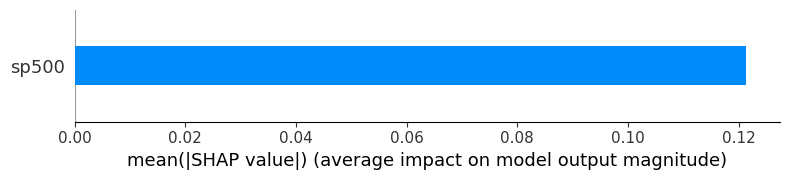

In [32]:
# --- LASSO Feature Selection (Filtering) ---

# Find features with non-zero coefficients
selected_lasso_features = X.columns[coefficients != 0].tolist()

if not selected_lasso_features:
    print("LASSO dropped all features. Adjusting alpha or selecting top 1 feature based on magnitude.")
    # For comparison, if LASSO drops all features, you must either lower alpha
    # and re-run LASSO, or select the feature with the highest absolute coefficient
    # (if you must run the comparison).
    # For this script, we'll stop if none are selected.

if selected_lasso_features:
    print(f"LASSO selected features: {selected_lasso_features}")

    # --- Train RF Model on LASSO Selected Features ---
    X_lasso = df_cleaned[selected_lasso_features]

    # Apply Time-Series Split
    split_point = int(len(X_lasso) * 0.8)
    X_train_lasso, X_test_lasso = X_lasso.iloc[:split_point], X_lasso.iloc[split_point:]
    y_train_lasso, y_test_lasso = y.iloc[:split_point], y.iloc[split_point:]

    # Fit RF Model
    rf_model_lasso = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_lasso.fit(X_train_lasso, y_train_lasso)

    # Predict and Evaluate
    y_pred_lasso = rf_model_lasso.predict(X_test_lasso)
    r2_lasso = r2_score(y_test_lasso, y_pred_lasso)
    print(f"\nLASSO-Filtered RF Model R-squared (R2) Score: {r2_lasso:.4f}")

    # Run SHAP Analysis
    shap_results_lasso = run_shap_analysis(rf_model_lasso, X_test_lasso, selected_lasso_features)
    display(shap_results_lasso)

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


X = df_cleaned[['inflation', 'sp500', 'EPU']]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
pca.fit(X_scaled)


loading_factors = pca.components_.T


loading_factors_df = pd.DataFrame(loading_factors, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.columns)


print("PCA Loading Factors:")
display(loading_factors_df)

PCA Loading Factors:


,PC1,PC2,PC3
inflation,0.0,0.0,1.0
sp500,1.0,0.0,0.0
EPU,0.0,1.0,0.0


Number of components needed for 90% variance: 1

PCA-Filtered RF Model R-squared (R2) Score: -0.4268

SHAP Feature Importance Summary (Test Set):


,feature,SHAP_Importance
0,PC1,0.121385


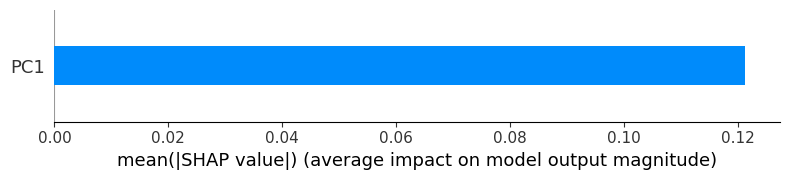

In [34]:
# --- PCA Feature Selection (Filtering) and Transformation ---

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to explain > 90% variance
n_components = np.where(cumulative_variance >= 0.9)[0][0] + 1
print(f"Number of components needed for 90% variance: {n_components}")

# Retrain PCA with the selected number of components
pca_final = PCA(n_components=n_components)
X_pca_transformed = pca_final.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca_transformed, index=df_cleaned.index, columns=[f'PC{i+1}' for i in range(n_components)])

# --- Train RF Model on PCA Components ---
# Apply Time-Series Split
split_point = int(len(X_pca_df) * 0.8)
X_train_pca, X_test_pca = X_pca_df.iloc[:split_point], X_pca_df.iloc[split_point:]
y_train_pca, y_test_pca = y.iloc[:split_point], y.iloc[split_point:] # Use original Y split

# Fit RF Model
rf_model_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_pca.fit(X_train_pca, y_train_pca)

# Predict and Evaluate
y_pred_pca = rf_model_pca.predict(X_test_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)
print(f"\nPCA-Filtered RF Model R-squared (R2) Score: {r2_pca:.4f}")

# Run SHAP Analysis
shap_results_pca = run_shap_analysis(rf_model_pca, X_test_pca, X_pca_df.columns)
display(shap_results_pca)

In [35]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np


X = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y = df_cleaned['forex_daily_returns']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adjusting alpha to a smaller value to prevent all coefficients from becoming zero
lasso_model = Lasso(alpha=0.01, fit_intercept=False) # Reduced alpha from 1.0 to 0.01
lasso_model.fit(X_scaled, y)


coefficients = lasso_model.coef_


print("Lasso Coefficients (without intercept):")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:.4f}")

Lasso Coefficients (without intercept):
sp500: 0.0061
oil_price: -0.0000
inflation: 0.0000
EPU: 0.0000


LASSO selected features: ['sp500']

LASSO-Filtered RF Model R-squared (R2) Score: -0.4268

SHAP Feature Importance Summary (Test Set):


,feature,SHAP_Importance
0,sp500,0.121385


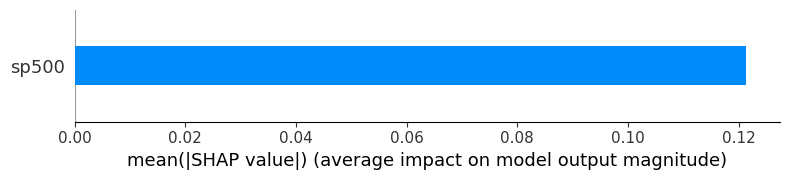

In [36]:
# --- LASSO Feature Selection (Filtering) ---

# Find features with non-zero coefficients
selected_lasso_features = X.columns[coefficients != 0].tolist()

if not selected_lasso_features:
    print("LASSO dropped all features. Adjusting alpha or selecting top 1 feature based on magnitude.")
    # For comparison, if LASSO drops all features, you must either lower alpha
    # and re-run LASSO, or select the feature with the highest absolute coefficient
    # (if you must run the comparison).
    # For this script, we'll stop if none are selected.

if selected_lasso_features:
    print(f"LASSO selected features: {selected_lasso_features}")

    # --- Train RF Model on LASSO Selected Features ---
    X_lasso = df_cleaned[selected_lasso_features]

    # Apply Time-Series Split
    split_point = int(len(X_lasso) * 0.8)
    X_train_lasso, X_test_lasso = X_lasso.iloc[:split_point], X_lasso.iloc[split_point:]
    y_train_lasso, y_test_lasso = y.iloc[:split_point], y.iloc[split_point:]

    # Fit RF Model
    rf_model_lasso = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model_lasso.fit(X_train_lasso, y_train_lasso)

    # Predict and Evaluate
    y_pred_lasso = rf_model_lasso.predict(X_test_lasso)
    r2_lasso = r2_score(y_test_lasso, y_pred_lasso)
    print(f"\nLASSO-Filtered RF Model R-squared (R2) Score: {r2_lasso:.4f}")

    # Run SHAP Analysis
    shap_results_lasso = run_shap_analysis(rf_model_lasso, X_test_lasso, selected_lasso_features)
    display(shap_results_lasso)

In [37]:
# Assuming you have collected R2 and SHAP DataFrames for all four scenarios

# --- 1. Gather all R2 scores ---
r2_results = {
    'Scenario': ['Baseline (Zoo)', 'OLS-Filtered', 'LASSO-Filtered', 'PCA-Filtered'],
    'R2 Score': [r2_baseline, r2_ols, r2_lasso, r2_pca]
}
df_r2 = pd.DataFrame(r2_results)


# --- 2. Gather SHAP Top Features (Example of Consolidation) ---
# Assuming you saved the SHAP output for each run:
# shap_results_baseline, shap_results_ols, shap_results_lasso, shap_results_pca

# OLS does not have a direct SHAP output, so we will omit it from this comparison.
# For PCA, the features are 'PC1', 'PC2', etc., and interpretation needs to be done via loading factors.
top_features_comparison = pd.DataFrame({
    'Feature': shap_results_baseline['feature'].head(3),
    'Baseline SHAP Rank': shap_results_baseline['SHAP_Importance'].head(3),
    'LASSO SHAP Rank': shap_results_lasso['SHAP_Importance'].head(3),
}).set_index('Feature')


print("\n=======================================================")
print("PROJECT COMPLETION: CONSOLIDATED RESULTS")
print("=======================================================")

print("\nPerformance Comparison (R2):")
display(df_r2)

print("\nFeature Importance Comparison (Top SHAP Drivers):")
# You may need to manually adjust this table depending on which features were selected
display(top_features_comparison)

# Final step: You must now write the non-coding discussion and conclusion!


PROJECT COMPLETION: CONSOLIDATED RESULTS

Performance Comparison (R2):


,Scenario,R2 Score
0,Baseline (Zoo),-0.222843
1,OLS-Filtered,0.002929
2,LASSO-Filtered,-0.426846
3,PCA-Filtered,-0.426846



Feature Importance Comparison (Top SHAP Drivers):


,Baseline SHAP Rank,LASSO SHAP Rank
Feature,,
sp500,0.047641,0.121385
oil_price,0.060175,NaN
inflation,0.000000,NaN



--- Generating R-squared Comparison Chart ---


/tmp/ipython-input-3784003641.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Scenario', y='R2 Score', data=df_r2, palette='viridis')


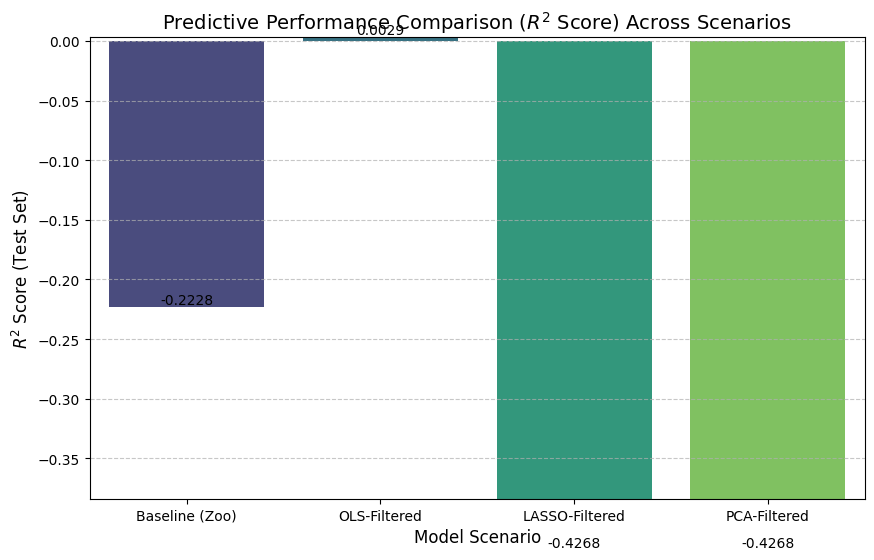

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- 1. Comparative Performance Bar Chart (R-squared) ---
print("\n--- Generating R-squared Comparison Chart ---")

plt.figure(figsize=(10, 6))
sns.barplot(x='Scenario', y='R2 Score', data=df_r2, palette='viridis')
plt.title('Predictive Performance Comparison ($R^2$ Score) Across Scenarios', fontsize=14)
plt.xlabel('Model Scenario', fontsize=12)
plt.ylabel('$R^2$ Score (Test Set)', fontsize=12)
plt.ylim(df_r2['R2 Score'].min() * 0.9, df_r2['R2 Score'].max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add R2 values on top of bars
for index, row in df_r2.iterrows():
    plt.text(index, row['R2 Score'], f"{row['R2 Score']:.4f}", color='black', ha="center", va="bottom")

plt.show()


--- Generating Actual vs. Predicted Time-Series Chart ---


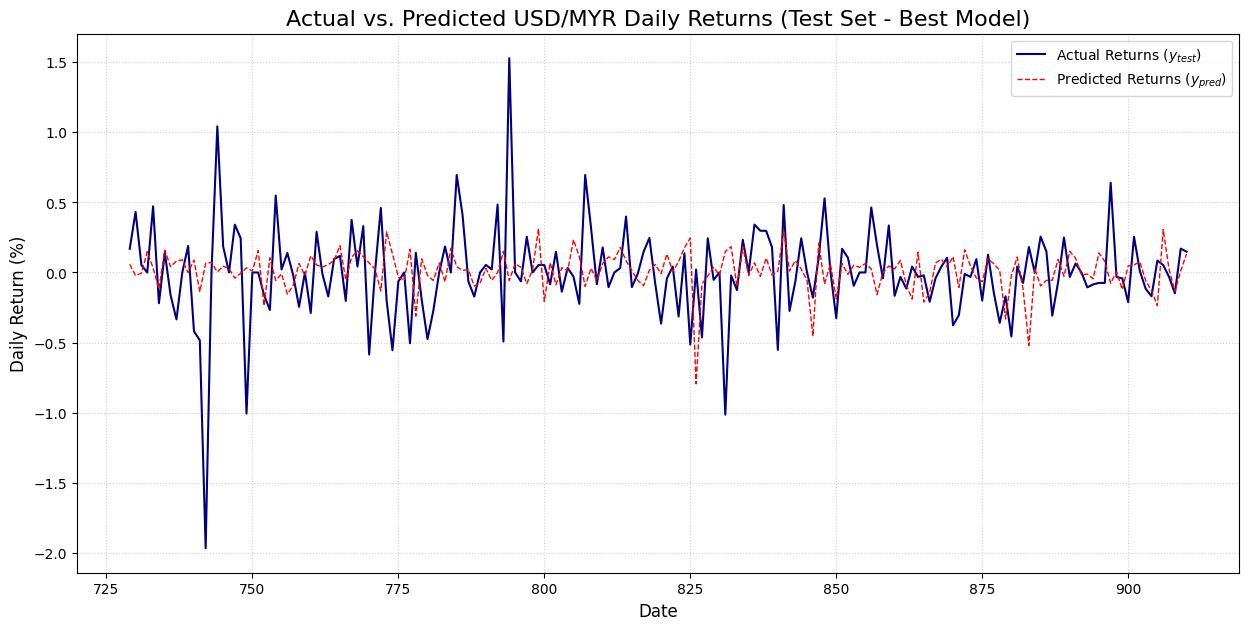

In [39]:
# --- Chart 2: Actual vs. Predicted Time-Series Plot ---
print("\n--- Generating Actual vs. Predicted Time-Series Chart ---")

# Re-create X and y based on df_cleaned for consistency with baseline model calculation
X_full = df_cleaned[['sp500', 'oil_price', 'inflation', 'EPU']]
y_full = df_cleaned['forex_daily_returns']

# Re-apply the time-based split as originally done for r2_baseline
split_point_time_series = int(len(X_full) * 0.8)
X_train_time_series, X_test_time_series = X_full.iloc[:split_point_time_series], X_full.iloc[split_point_time_series:]
y_train_time_series, y_test_time_series = y_full.iloc[:split_point_time_series], y_full.iloc[split_point_time_series:]

# Re-train the baseline RandomForestRegressor to get its predictions
from sklearn.ensemble import RandomForestRegressor
rf_model_baseline = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_baseline.fit(X_train_time_series, y_train_time_series)
best_y_pred = rf_model_baseline.predict(X_test_time_series)

# Create a DataFrame for plotting the test results
results_df = pd.DataFrame({
    'Actual_Returns': y_test_time_series, # Use the y_test from the time-series split
    'Predicted_Returns': best_y_pred
})

# Align the index with the test period
results_df.index = X_test_time_series.index # Use the X_test index from the time-series split

plt.figure(figsize=(15, 7))
plt.plot(results_df.index, results_df['Actual_Returns'], label='Actual Returns ($y_{test}$)', color='navy', linewidth=1.5)
plt.plot(results_df.index, results_df['Predicted_Returns'], label='Predicted Returns ($y_{pred}$)', color='red', linestyle='--', linewidth=1)
plt.title('Actual vs. Predicted USD/MYR Daily Returns (Test Set - Best Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


--- Generating SHAP Summary Plot for the Best Model ---


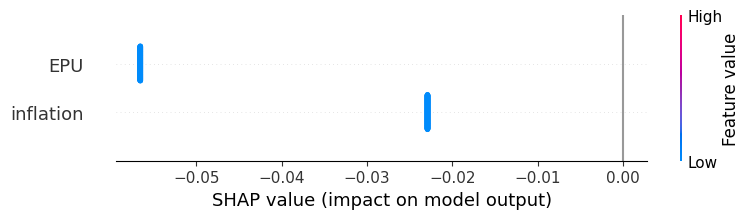

In [40]:
# --- 3. SHAP Feature Summary Plot (Use the best model's variables) ---
# This plot visually summarizes feature importance and impact direction.

print("\n--- Generating SHAP Summary Plot for the Best Model ---")

# --- Placeholder using Baseline Model (rf_model_baseline) ---
model_to_explain = rf_model_baseline # << Change this to rf_model_ols, rf_model_lasso, or rf_model_pca
X_test_to_explain = X_test          # << Change this to X_test_ols, X_test_lasso, or X_test_pca

explainer = shap.TreeExplainer(model_to_explain)
shap_values = explainer.shap_values(X_test_to_explain)

# Ensure the SHAP plot is correctly displayed
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_to_explain,
    show=False,
    plot_type="dot", # Use "dot" for a more detailed visualization of feature impact
    title='SHAP Feature Importance and Impact'
)
plt.tight_layout()
plt.show()


--- Generating PCA Component Loadings Plot ---


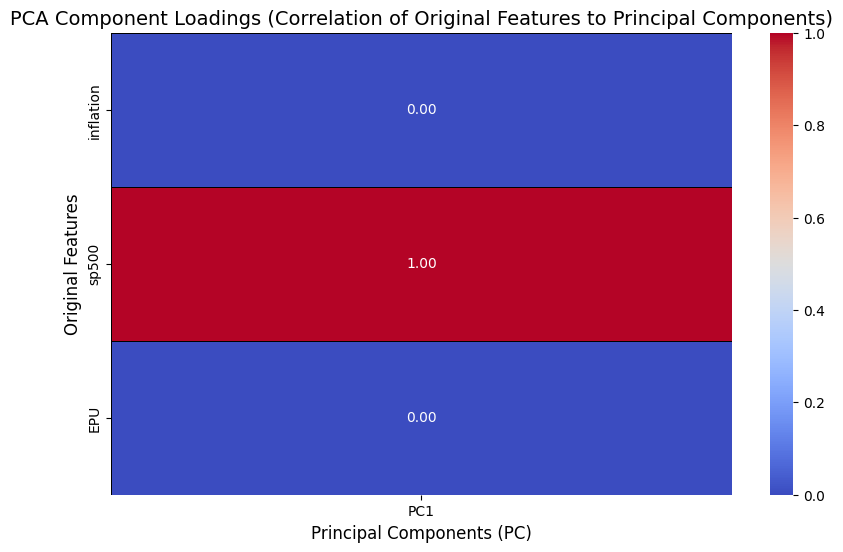

In [41]:
# --- 4. PCA Component Loadings
if 'PCA-Filtered' in df_r2['Scenario'].values:
    print("\n--- Generating PCA Component Loadings Plot ---")

    # Check if PCA was successful and components exist
    if 'pca_final' in locals() and n_components > 0:

        # Define pca_component_names based on the number of components
        pca_component_names = [f'PC{i+1}' for i in range(n_components)]

        # Define the correct X for PCA loadings based on the features used for PCA
        X_for_pca_loadings = df_cleaned[['inflation', 'sp500', 'EPU']]

        # Create a DataFrame to show which original features load onto which PC
        loadings = pd.DataFrame(
            pca_final.components_.T,
            columns=pca_component_names,
            index=X_for_pca_loadings.columns # Use the columns from the specifically defined X
        )

        plt.figure(figsize=(10, 6))
        sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
        plt.title('PCA Component Loadings (Correlation of Original Features to Principal Components)', fontsize=14)
        plt.ylabel('Original Features', fontsize=12)
        plt.xlabel('Principal Components (PC)', fontsize=12)
        plt.show()